# Preprocessing

Mounting to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Importing required packages

In [ ]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import pickle
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.utils import simple_preprocess
from gensim.models.doc2vec import TaggedDocument
from sklearn.model_selection import train_test_split
from google.colab import files
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import random

In [ ]:
# Reading original data
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/lastfm-dataset-1K.tar/lastfm-dataset-1K/lastfm-dataset-1K/userid-timestamp-artid-artname-traid-traname.tsv',sep="\t", on_bad_lines='skip')
# Renaming the columns
data.columns =['userid', 'timestamp', 'artist_id', 'artist_name', 'track_id', 'track_name']
print(data.shape)
# Dropping rows where track id or track name is null
data['track_name'].isnull().values.any()
data=data.dropna(subset=['track_name'])
print(data.shape)
data['track_id'].isnull().values.any()
data=data.dropna(subset=['track_id'])
print(data.shape)
# resetting the index
data.reset_index(drop=True)

In [ ]:
tracks_per_user = data.groupby('userid')['track_id'].count()

# Calculate max, min, and average
max_tracks = tracks_per_user.max()
min_tracks = tracks_per_user.min()
avg_tracks = tracks_per_user.mean()

print(f"Maximum tracks played per user: {max_tracks}")
print(f"Minimum tracks played per user: {min_tracks}")
print(f"Average tracks played per user: {avg_tracks:.2f}")


Maximum tracks played per user: 172042
Minimum tracks played per user: 2
Average tracks played per user: 17072.72


In [ ]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Group data by user and calculate time period for each user
user_time_periods = data.groupby('userid')['timestamp'].apply(lambda x: x.max() - x.min())

# Calculate min, max, and average time period
min_time_period = user_time_periods.min()
max_time_period = user_time_periods.max()
avg_time_period = user_time_periods.mean()

print(f"Minimum time period per user profile: {min_time_period}")
print(f"Maximum time period per user profile: {max_time_period}")
print(f"Average time period per user profile: {avg_time_period}")


Minimum time period per user profile: 0 days 00:37:57
Maximum time period per user profile: 2291 days 20:48:03
Average time period per user profile: 860 days 00:45:05.863911280


In [ ]:
track_popularity = data.groupby('track_id')['userid'].nunique()

# Find the most popular track and the number of users
most_popular_track = track_popularity.idxmax()
num_users_listened = track_popularity.max()

print(f"The most popular track is {most_popular_track} with {num_users_listened} users.")


The most popular track is 9e2ad5bc-c6f9-40d2-a36f-3122ee2072a3 with 346 users.


In [ ]:
data[data['track_id']=='9e2ad5bc-c6f9-40d2-a36f-3122ee2072a3']['track_name'].tolist()[0]

'Karma Police'

In [ ]:
tracks_with_one_listener = (track_popularity == 1).sum()
print(f"The number of tracks with only one listener: {tracks_with_one_listener}")

The number of tracks with only one listener: 502134


In [ ]:
# Convert object type to datetime object
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp'] = pd.to_datetime(data['timestamp'].dt.strftime("%Y-%m-%d %H:%M:%S.%f"))
print(data.dtypes)


Unnamed: 0              int64
userid                 object
timestamp      datetime64[ns]
artist_id              object
artist_name            object
track_id               object
track_name             object
dtype: object


In [ ]:
data.shape

(16936134, 7)

Creating Sessions

In [ ]:

# Sort the data by user and timestamp to ensure sequential order
data=data.groupby(['userid']).apply(lambda x: x.sort_values(['timestamp'], ascending=True)).reset_index(drop=True)

# Function to create unique session IDs based on time difference
def create_session_ids(data, threshold_time):
    session_ids = []
    prev_user = None
    prev_timestamp = None
    session_id_counter = 0

    for index, row in data.iterrows():
        user_id = row['userid']
        timestamp = pd.to_datetime(row['timestamp'])

        if prev_user is None or user_id != prev_user or (timestamp - prev_timestamp).total_seconds() > threshold_time:
            # Start a new session for a different user or if the time difference exceeds the threshold
            session_id_counter += 1

        session_ids.append(session_id_counter)

        prev_user = user_id
        prev_timestamp = timestamp

    return session_ids

# Set the threshold time in seconds (Here, 360 seconds = 6 minutes)
threshold_time_seconds = 360





In [ ]:
# Create unique session IDs based on the time difference
data['session_id'] = create_session_ids(data, threshold_time_seconds)

In [ ]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv',index=False)

In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/clean_data.csv', on_bad_lines='skip',index_col=False)

Creating Tagged document for Doc2Vec

In [ ]:
def create_tagged_document(data):
    tagged_data = []
    words=[]
    session_id=1
    for idx, row in data.iterrows():
      if row['session_id'] == session_id:
        words.append(row['track_id'])
      else:
        tagged_data.append(TaggedDocument(words=words, tags=[str(session_id)]))
        words=[]
        words.append(row['track_id'])
        session_id=row['session_id']
    return tagged_data

tagged_data = create_tagged_document(data)

#Save the tagged document for future use
with open('/content/drive/MyDrive/Colab Notebooks/Project/tagged_documents.pkl', 'wb') as f:
    pickle.dump(tagged_data, f)



Doc2Vec implemetation

In [ ]:
# Split data into train and test sets
train_data, test_data = train_test_split(tagged_data, test_size=0.6, random_state=42)

In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'wb') as f:
    pickle.dump(train_data, f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'wb') as f:
    pickle.dump(test_data, f)


In [ ]:
with open('/content/drive/MyDrive/Colab Notebooks/Project/train_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
with open('/content/drive/MyDrive/Colab Notebooks/Project/test_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

In [ ]:
# Split test into validation and test sets
val_data, testing_data = train_test_split(test_data, test_size=0.8, random_state=42)

In [ ]:
print(data.shape)
print(len(train_data))
print(len(testing_data))
print(len(val_data))

(16936134, 7)
1468799
1762560
440639


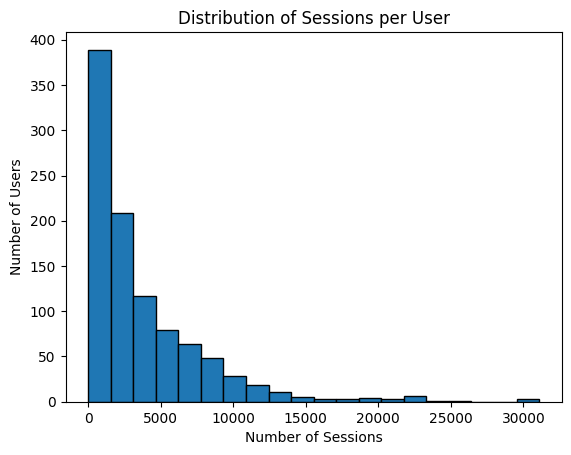

In [ ]:
sessions_per_user = data.groupby('userid')['session_id'].nunique()

# Plot the distribution of sessions per user using a histogram
plt.hist(sessions_per_user, bins=20, edgecolor='black')
plt.xlabel("Number of Sessions")
plt.ylabel("Number of Users")
plt.title("Distribution of Sessions per User")
plt.show()


In [ ]:
# Training the Doc2Vec model
vector_size = 100
window = 10
epochs = 100
model = Doc2Vec(vector_size=vector_size, window=window, epochs=epochs, dm=1)
model.build_vocab(train_data)
model.train(train_data, total_examples=model.corpus_count, epochs=model.epochs)


In [ ]:
# Assuming 'model' is the trained model object that you want to save
file_path = '/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_10_epoch_100.pkl'
with open(file_path, 'wb') as file:
    pickle.dump(model, file)


In [ ]:
# Load the model from the downloaded file
with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_5_epoch_50.pkl', 'rb') as file:
    model1 = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_10_epoch_50.pkl', 'rb') as file:
    model2 = pickle.load(file)

with open('/content/drive/MyDrive/Colab Notebooks/Project/doc2vec_win_10_epoch_100.pkl', 'rb') as file:
    model3 = pickle.load(file)



Visualizing similar songs

In [ ]:
#song_id='8f451908-aef9-4a9b-950e-f560ba56ce7d'
song_id='49710f40-e75f-49a3-9b1f-fc7fc4894a9f'
simsongs=model1.wv.most_similar(song_id)
song_name = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in simsongs]
artist_name = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in simsongs]
song_vector= [model1.wv[node] for node, score in simsongs]
sim_score=[score for node, score in simsongs]
#adding the actual song for vizualization
song_name.append(data[data['track_id']==song_id]['track_name'].tolist()[0])
artist_name.append(data[data['track_id']==song_id]['artist_name'].tolist()[0])
song_vector.append(model1.wv[song_id])


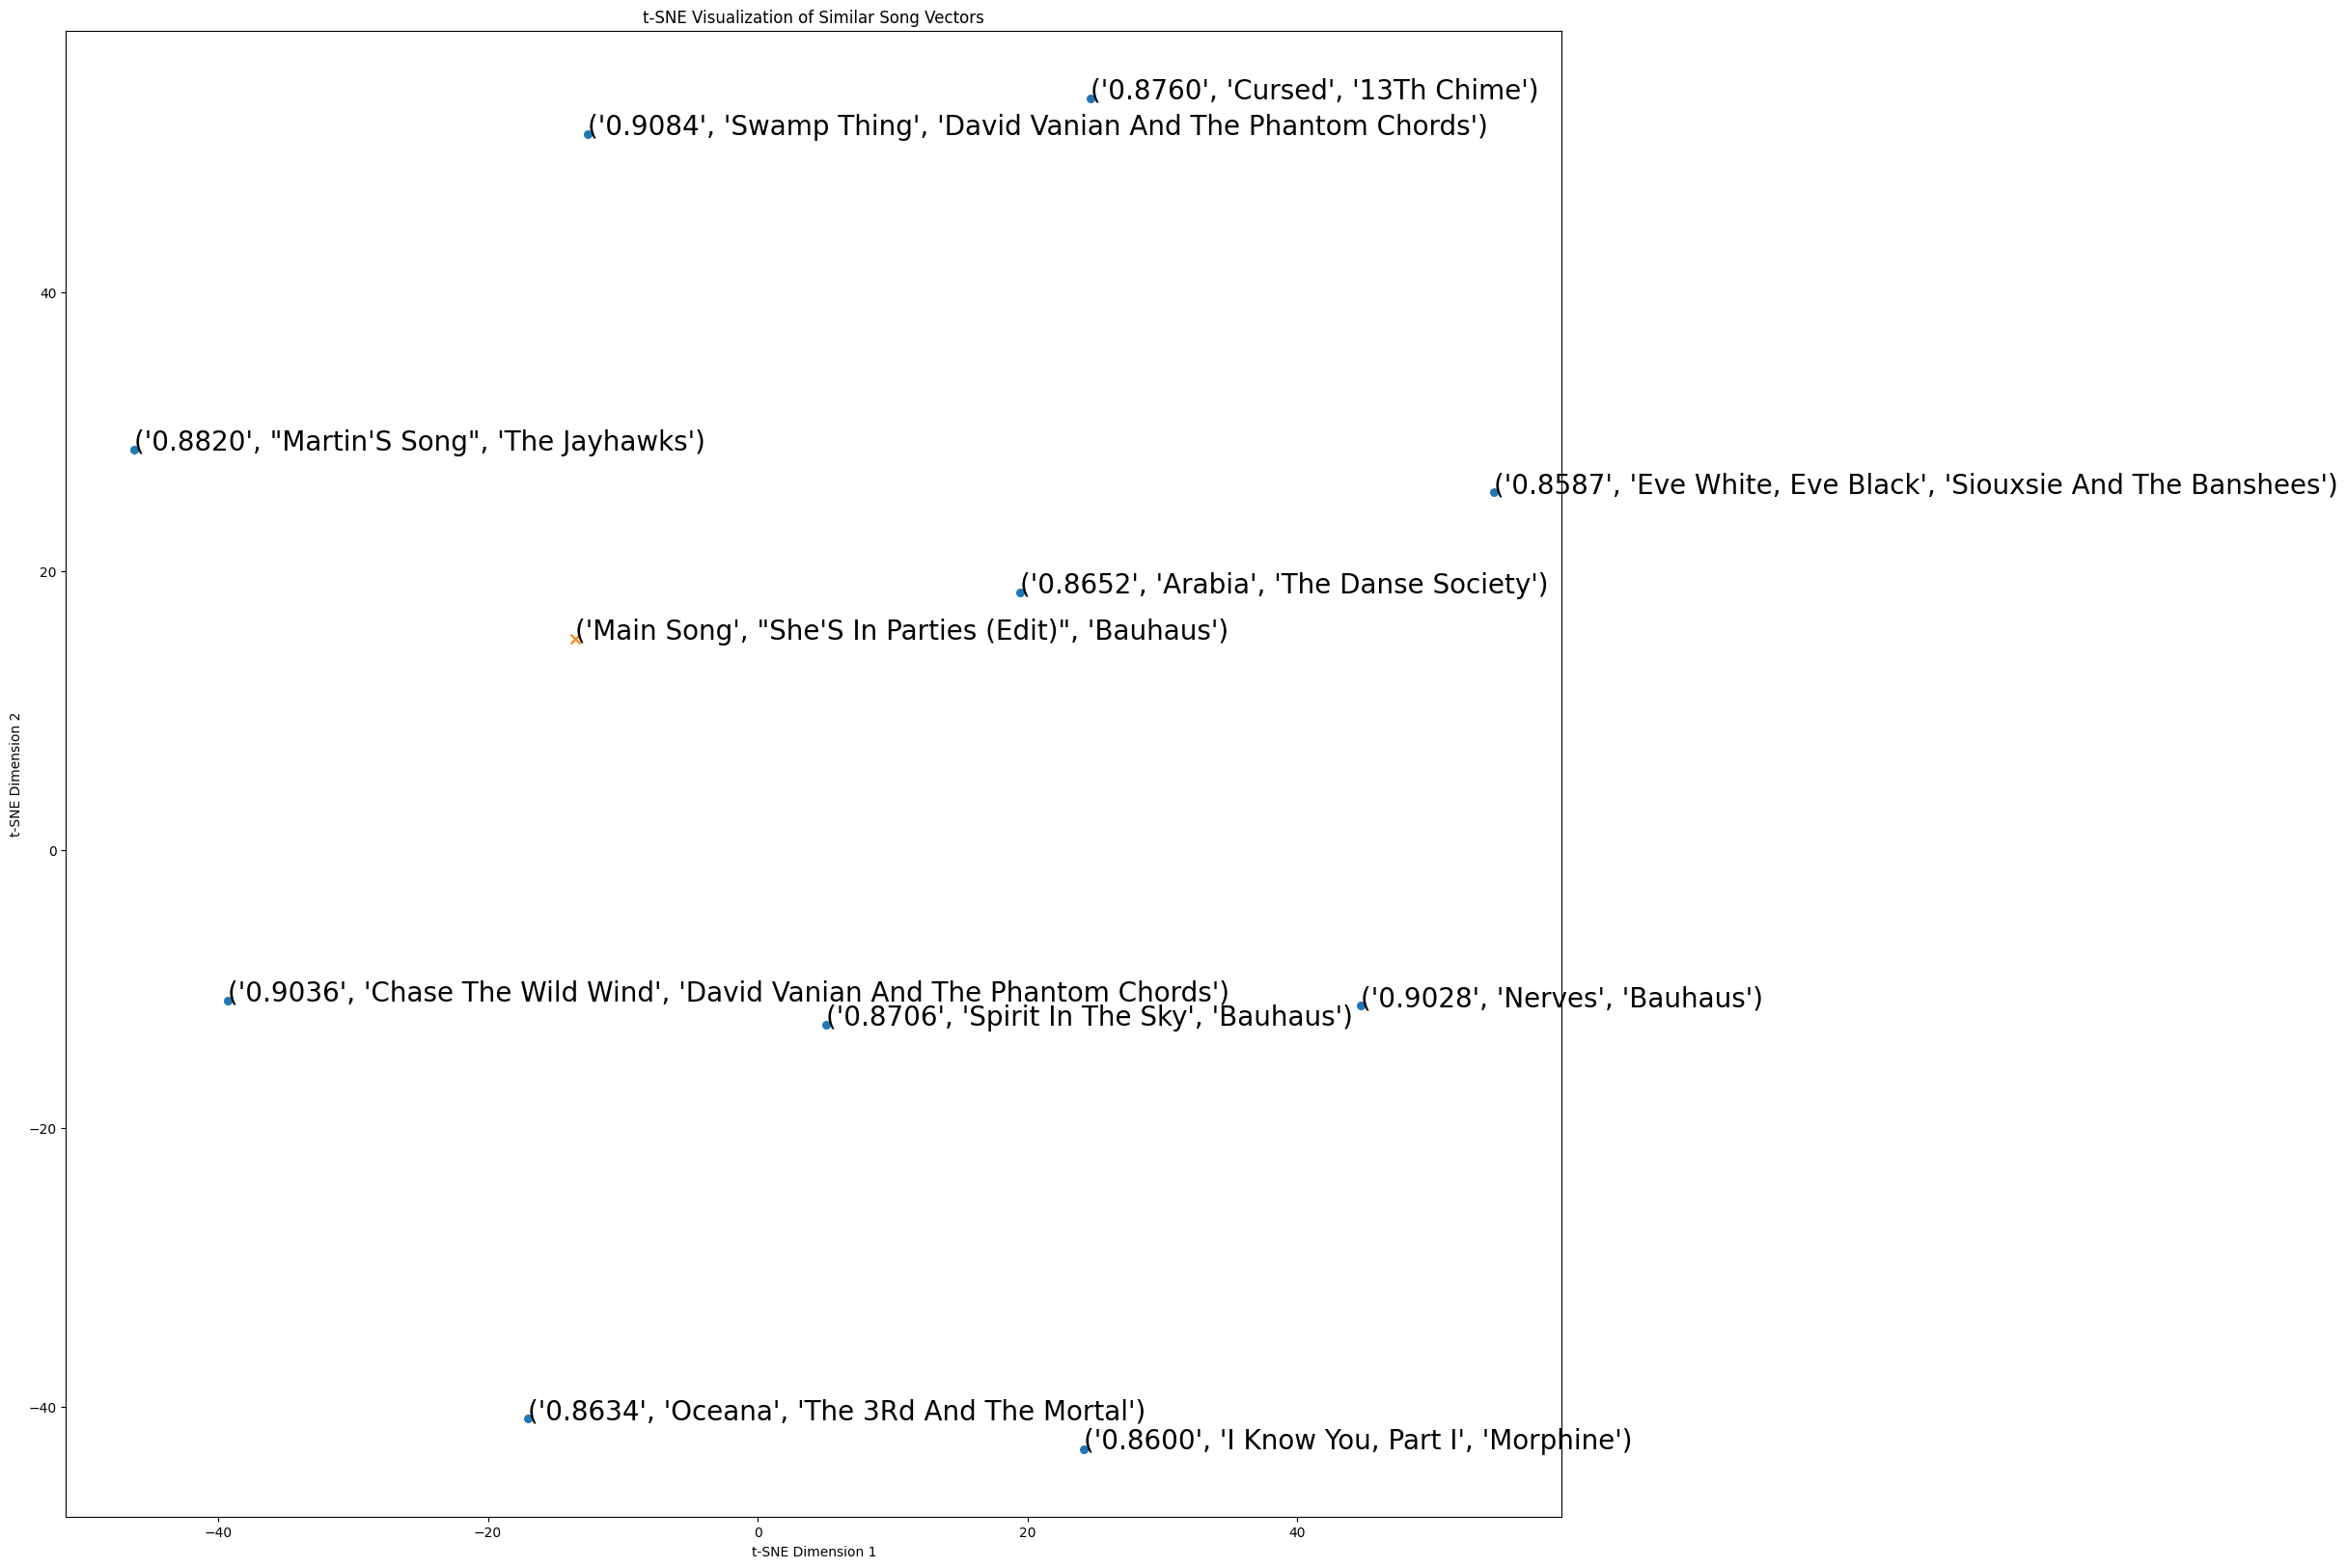

In [ ]:
# Extract song IDs and vectors
song_ids = song_name
song_vector=np.array(song_vector)

# Standardize the vectors
scaler = StandardScaler()
scaled_vectors = scaler.fit_transform(song_vector)

# Apply t-SNE for dimensionality reduction and visualization
tsne = TSNE(n_components=2, random_state=42,perplexity=10)
tsne_results = tsne.fit_transform(scaled_vectors)

# Create a scatter plot for visualization
plt.figure(figsize=(20, 20))
plt.scatter(tsne_results[:10, 0], tsne_results[:10, 1], marker='o', s=30)
plt.scatter(tsne_results[10, 0], tsne_results[10, 1], marker='x', s=50)
plt.title("t-SNE Visualization of Similar Song Vectors")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

# Annotate points with song IDs
for i in range(0,len(sim_score)):
    #enumerate(sim_score),song_ids):
    plt.annotate(("%.4f" % sim_score[i],song_ids[i],artist_name[i]), (tsne_results[i, 0], tsne_results[i, 1]), fontsize=20)
plt.annotate(("Main Song",song_ids[10],artist_name[10]), (tsne_results[10, 0], tsne_results[10, 1]), fontsize=20)
plt.show()


In [ ]:
def get_test_session(test_data,index):
  if len(test_data[index][0])<3:
    print("Choose some other test session as this one is too small to suggest next song.")
    return (0,0,0)
  else:
    next_song_id=test_data[index][0][-1]
    next_song=data[data['track_id']==next_song_id]['track_name'].tolist()[0]
    next_artist=data[data['track_id']==next_song_id]['artist_name'].tolist()[0]
    session=test_data[index][0][:-1]
    return session,next_song,next_artist

def recommend_top_songs(session,model):
  session_vector=model.infer_vector(session)
  simsession = model.dv.most_similar([session_vector])
  try:
    simsongs = model.wv.most_similar(session[-1],topn=5)
  except KeyError:
    simsongs = []
    pass
  recommend_songs=[]
  recommend_artist=[]
  for ses_id,sim_score in simsession:
    #if sim_score>=0.7:
      session_songs=data[data['session_id']==int(ses_id)]['track_name'].tolist()
      session_artists=data[data['session_id']==int(ses_id)]['artist_name'].tolist()
      recommend_songs.extend(session_songs)
      recommend_artist.extend(session_artists)
  # Getting uniques recommended songs in the same order
  unique_recom_songs=[]
  unique_recom_artists=[]
  for i in recommend_songs:
    if i not in unique_recom_songs:
      unique_recom_songs.append(i)
  for i in recommend_artist:
    if i not in unique_recom_artists:
      unique_recom_artists.append(i)
  if simsongs!=[]:
    songs = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in simsongs]
    artist = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in simsongs]
    unique_recom_songs.extend(songs)
    unique_recom_artists.extend(artist)
  return unique_recom_songs,unique_recom_artists


In [ ]:
session,actual_next_song=get_test_session(test_data,290002)
recommend_top_songs(session)

['8f451908-aef9-4a9b-950e-f560ba56ce7d', '8f451908-aef9-4a9b-950e-f560ba56ce7d', 'c720e22d-2eb0-45cd-9c87-edc0f2138a36']
c720e22d-2eb0-45cd-9c87-edc0f2138a36
2822959
0.9194144010543823
['Sweetheart Come', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road']
1999797
0.9180600047111511
['Sweetheart Come', 'The Sorrowful Wife']
1474527
0.9118371605873108
['Credence', 'Karma']
2716822
0.9051225781440735
['Bad Trails', 'Prismism', 'Snare Hangar', 'Tij']
3366206
0.9043607711791992
['Sweetheart Come', 'The Sorrowful Wife']
2098373
0.903694748878479
["It'S A Long Way To The Top (If You Wanna Rock 'N' Roll)", "It'S A Long Way To The Top (If You Wanna Rock 'N' Roll)", "Rock 'N' Roll Singer"]
407050
0.9035896062850952
['Bad Trails', 'Prismism', 'Snare Hangar', 'Tij']
185080
0.9035858511924744
['Labels', '4Th Chamber', "Shadowboxin'"]
3046360
0.9035764336585999
['Washing My Hands Of It', 'Above The 60Th Parallel']
216638
0.9035269021987915
['Sweetheart Come', 'The Sorrowful Wife', '

['Sweetheart Come',
 'The Sorrowful Wife',
 'We Came Along This Road',
 'Credence',
 'Karma',
 'Bad Trails',
 'Prismism',
 'Snare Hangar',
 'Tij',
 "It'S A Long Way To The Top (If You Wanna Rock 'N' Roll)",
 "Rock 'N' Roll Singer",
 'Labels',
 '4Th Chamber',
 "Shadowboxin'",
 'Washing My Hands Of It',
 'Above The 60Th Parallel']

**Inference:** The different sessions indicate that similar sessions are found among different users too, across the whole session data, and not just one specific test user data.

In [ ]:
def hit_rate(test_data, model):
    total_sessions = len(test_data)
    correct_recommendations = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        actual_total_sessions=actual_total_sessions+1
        recommended_songs,recommended_artist = recommend_top_songs(session,model)
        print("recommended songs",recommended_songs)
        print("actual song",actual_next_song)
        print("recommended artists",recommended_artist)
        print("actual artist",actual_next_artist)
        if actual_next_song in recommended_songs:
          correct_recommendations += 1
        elif actual_next_artist in recommended_artist:
          correct_recommendations += 0.5


    hit_rate = correct_recommendations / actual_total_sessions
    print(actual_total_sessions)
    return hit_rate

In [ ]:
hit_rate(test_data[290002:290003])

recommended songs ['The Sorrowful Wife', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Gates To The Garden', 'Darker With The Day', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'The Sorrowful Wife', 'Sweetheart Come', 'The Sorrowful Wife', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Gates To The Garden', 'Darker With The Day', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road', 'Sweetheart Come', 'Sweetheart Come', 'The Sorrowful Wife', 'We Came Along This Road']
actual song The Sorrowful Wife
recommended artists ['Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick Cave & The Bad Seeds', 'Nick 

1.0

Partial Hit Rate

In [ ]:
hit_rate(test_data[28:29])

recommended songs ['Heaven Forbid', 'Just A Girl (Radio Edit)', 'Not An Addict', 'La Marée Haute', 'Tomorrow Is A Closed Gate (Dead For So Long)', 'Starforsaken', 'Good Goodnight', 'Six Days At The Bottom Of The Ocean', 'Harder', 'Aievea', 'La Pièce Vide', "Winter'S Warning: Ii. Spring Requiem", 'Prieteni', 'Is This Love', 'Portrait Of A Deadly Nightshade', 'Glue Of The World', 'Outroduction', "New Year'S Day", 'Sweet Lilith Of My Dreams', 'New Pain', 'Cruci-Fiction In Space', 'Heaven Forbid', 'Your Name Here (Sunrise Highway)', 'Epiphany', 'Grace Kelly', 'The Day And The Time (Feat. Gustavo Cerati)', 'The Sweet Escape', 'Heaven Forbid', 'She Wolf (Live)', 'Traición A La Mejicana', 'Good Old-Fashioned Lover Boy', 'Ojos Así', 'Heaven Forbid', 'The Day And The Time (Feat. Gustavo Cerati)', 'Through With You', 'El Salmón', 'Those Crimson Tears', 'Heaven Forbid', 'Stumbling Through The Dark', 'Run', 'Better That We Break', 'She Is', 'Now Comes The Night', 'Innocence', 'Jazz Thieves', 'Anot

0.5

Session Similarity

In [ ]:
hit_rate(val_data[:15])

Song Similarity

In [ ]:
hit_rate(val_data[:15])

Combined Similarity

In [ ]:
hit_rate(val_data[:15])

MRR evaluation

Since we are trying to calculate MRR it would be better to only consider song similarity rather than song and session similarity because session similarity does not have ranking for songs but sessions.

In [ ]:
def recommend_top_songs_songsim(session,model):
  session_vector=model.infer_vector(session)
  #simsession = model.dv.most_similar([session_vector])
  try:
    simsongs = model.wv.most_similar(session[-1],topn=10)
  except KeyError:
    simsongs = []
    pass
  unique_recom_songs=[]
  unique_recom_artists=[]
  if simsongs!=[]:
    songs = [data[data['track_id']==node]['track_name'].tolist()[0] for node, score in simsongs]
    artist = [data[data['track_id']==node]['artist_name'].tolist()[0] for node, score in simsongs]
    unique_recom_songs.extend(songs)
    unique_recom_artists.extend(artist)
  return unique_recom_songs,unique_recom_artists

def MRR(test_data, model):
    total_sessions = len(test_data)
    sum_reciprocal_rank = 0
    actual_total_sessions=0
    for i in range(0,total_sessions):
      session,actual_next_song,actual_next_artist=get_test_session(test_data,i)
      if (session,actual_next_song,actual_next_artist)==(0,0,0):
        continue
      else:
        actual_total_sessions=actual_total_sessions+1
        recommended_songs,recommended_artist = recommend_top_songs_songsim(session,model)
        print("recommended songs",recommended_songs)
        print("actual song",actual_next_song)
        print("recommended artists",recommended_artist)
        print("actual artist",actual_next_artist)
        if actual_next_song in recommended_songs:
          rank = recommended_songs.index(actual_next_song)+1 #because we start from 0 index
          print(rank)
          sum_reciprocal_rank += 1.0/rank
          print(sum_reciprocal_rank)


    mrr = sum_reciprocal_rank / actual_total_sessions
    print(actual_total_sessions)
    return mrr

Hyper Parameter tuning

win_5_epoch_50


In [ ]:
hit_rate(val_data[:55],model1)

In [ ]:
MRR(val_data[:55],model1)

win_10_epoch_50

In [ ]:
hit_rate(val_data[:55],model2)

In [ ]:
MRR(val_data[:55],model2)

win_10_epoch_100

In [ ]:
hit_rate(val_data[:55],model3)

In [ ]:
MRR(val_data[:55],model3)

Final Testing

In [ ]:
hit_rate(testing_data[:150],model1)

In [ ]:
MRR(testing_data[:150],model1)